In [5]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import nn_l2_mean
slim = tf.contrib.slim
ds = tf.contrib.distributions
from universal_divergence import estimate

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd ..

/home/data/bruno/diff-game


In [6]:
tf.reset_default_graph()


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [7]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [8]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [9]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
    lambd=1e-5
)

## Function for Symplectic gradient adjustment

## Construct model and training ops

In [10]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    print('rmsprop')
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(g_train_op, d_train_op)

elif params['optimizer'] == 'sgd':    
    d_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(d_train_op,g_train_op)

elif params['optimizer'] == 'georgios': 
    print('georgios')

#     optimizer = tf.train.GradientDescentOptimizer(params['disc_learning_rate'])
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    
    variables = disc_vars + gen_vars
    grads = d_grads + g_grads
    
    var_updates = []
    for grad, var in zip(grads, variables):
        var_updates.append(var.assign_sub(params['disc_learning_rate'] * grad - params['lambd'] * var))
    train_op = tf.group(*var_updates)
    
#     apply_vec = [(g - params['lambd'] * v, v)for (g, v) in zip(grads, variables)]
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)
    
# elif params['optimizer'] == 'consensus': 
#     print('consensus')
#     d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
#     g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])
    
#     optimizer = tf.train.RMSPropOptimizer(params['disc_learning_rate'], use_locking=True)

    
# #     dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
# #     gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)
    
#     d_grads = tf.gradients(loss, disc_vars)
#     g_grads = tf.gradients(-loss, gen_vars)
    
#     variables = disc_vars + gen_vars
#     grads = d_grads + g_grads
    

#     # Reguliarizer
#     reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
#     # Jacobian times gradiant
#     Jgrads = tf.gradients(reg, variables)
    
#     apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)

rmsprop


## Train

In [11]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

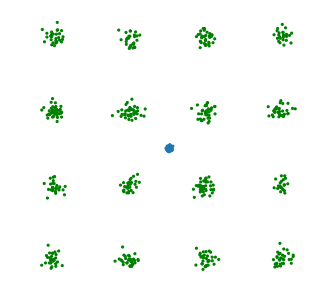

  0%|          | 7/20001 [00:07<6:02:54,  1.09s/it] 

dist =  22.720983192346267
kl =  12.244795992978604


  1%|          | 213/20001 [00:16<24:56, 13.22it/s] 

dist =  23.79086121788335
kl =  3.802510315567194


  2%|▏         | 409/20001 [00:24<19:43, 16.55it/s]

dist =  29.020174959921942
kl =  7.573744869087129


  3%|▎         | 611/20001 [00:33<17:37, 18.34it/s]

dist =  24.668906255053983
kl =  3.7937712742054273


  4%|▍         | 810/20001 [00:41<16:30, 19.37it/s]

dist =  11.909549341964405
kl =  4.029049602736629


  5%|▌         | 1007/20001 [00:50<15:43, 20.14it/s]

dist =  3.140568730055174
kl =  2.8985408209208514


  6%|▌         | 1208/20001 [00:58<15:08, 20.69it/s]

dist =  0.0314379182363902
kl =  2.0843134725745975


  7%|▋         | 1409/20001 [01:07<14:44, 21.03it/s]

dist =  0.020445815533305097
kl =  2.0665903258418488


  8%|▊         | 1610/20001 [01:15<14:24, 21.27it/s]

dist =  0.019150182479097135
kl =  2.0933018210224925


  9%|▉         | 1809/20001 [01:24<14:10, 21.38it/s]

dist =  0.025200671935198437
kl =  2.100745810732573


 10%|▉         | 1995/20001 [01:27<13:12, 22.71it/s]

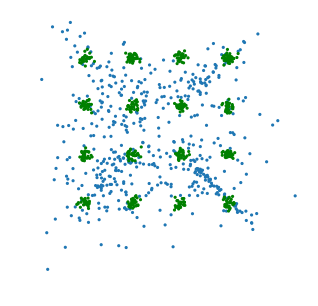

 10%|█         | 2008/20001 [01:33<13:59, 21.43it/s]

dist =  0.02079315357978796
kl =  2.126891373883677


 11%|█         | 2208/20001 [01:42<13:45, 21.56it/s]

dist =  0.024698721007364564
kl =  2.157605580965812


 12%|█▏        | 2412/20001 [01:51<13:32, 21.65it/s]

dist =  0.025730884920747932
kl =  2.3487879565875622


 13%|█▎        | 2607/20001 [02:00<13:26, 21.56it/s]

dist =  0.02978301630732523
kl =  2.4986358078964748


 14%|█▍        | 2809/20001 [02:09<13:15, 21.62it/s]

dist =  0.029064956611633025
kl =  2.4701167439210985


 15%|█▌        | 3014/20001 [02:18<13:00, 21.76it/s]

dist =  0.025896899383983693
kl =  2.255830610463328


 16%|█▌        | 3213/20001 [02:27<12:48, 21.85it/s]

dist =  0.025484333222082007
kl =  2.121493381499335


 17%|█▋        | 3409/20001 [02:35<12:36, 21.94it/s]

dist =  0.03227869524873093
kl =  2.115626907391792


 18%|█▊        | 3610/20001 [02:44<12:25, 21.97it/s]

dist =  0.02746156129814197
kl =  1.9993768509574745


 19%|█▉        | 3810/20001 [02:52<12:14, 22.06it/s]

dist =  0.04093280761665119
kl =  2.2009897630679913


 20%|█▉        | 3995/20001 [02:55<11:44, 22.72it/s]

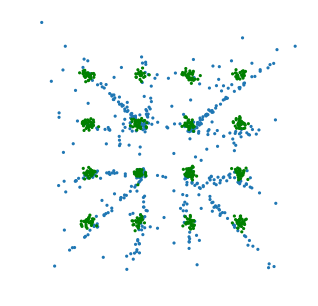

 20%|██        | 4008/20001 [03:01<12:05, 22.04it/s]

dist =  0.03622935403428313
kl =  2.0363717207101018


 21%|██        | 4207/20001 [03:10<11:55, 22.07it/s]

dist =  0.0315288828857344
kl =  1.6736016940624063


 22%|██▏       | 4412/20001 [03:20<11:48, 22.00it/s]

dist =  0.026471477394759343
kl =  1.4613590556302114


 23%|██▎       | 4611/20001 [03:29<11:38, 22.05it/s]

dist =  0.022390751508438462
kl =  1.563032257471889


 24%|██▍       | 4814/20001 [03:37<11:26, 22.13it/s]

dist =  0.0330694355524201
kl =  1.74944814068057


 25%|██▌       | 5015/20001 [03:45<11:14, 22.21it/s]

dist =  0.02963134680181155
kl =  1.7381322056502317


 26%|██▌       | 5213/20001 [03:54<11:04, 22.27it/s]

dist =  0.02564148311370117
kl =  1.7464970025560995


 27%|██▋       | 5413/20001 [04:02<10:53, 22.33it/s]

dist =  0.012476133227020821
kl =  0.8522806911727243


 28%|██▊       | 5609/20001 [04:10<10:43, 22.36it/s]

dist =  0.01759509192419932
kl =  1.2201597545720442


 29%|██▉       | 5811/20001 [04:19<10:33, 22.41it/s]

dist =  0.015574113056585922
kl =  1.2268579333860332


 30%|██▉       | 5995/20001 [04:22<10:13, 22.85it/s]

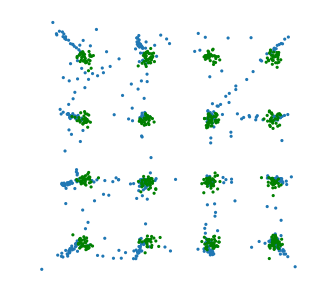

 30%|███       | 6009/20001 [04:27<10:23, 22.43it/s]

dist =  0.024147825004688733
kl =  1.5233458829851756


 31%|███       | 6209/20001 [04:36<10:14, 22.45it/s]

dist =  0.014347965360953363
kl =  0.8396367974554177


 32%|███▏      | 6410/20001 [04:45<10:06, 22.42it/s]

dist =  0.010762043439069113
kl =  0.6479570288923449


 33%|███▎      | 6608/20001 [04:54<09:57, 22.41it/s]

dist =  0.017801022251811602
kl =  1.2966477441679203


 34%|███▍      | 6806/20001 [05:03<09:47, 22.45it/s]

dist =  0.024276262158905496
kl =  1.5055726876900537


 35%|███▌      | 7011/20001 [05:11<09:37, 22.50it/s]

dist =  0.014292065437866383
kl =  0.9726114423202539


 36%|███▌      | 7209/20001 [05:20<09:28, 22.52it/s]

dist =  0.012658340770748523
kl =  1.1012876840108325


 37%|███▋      | 7406/20001 [05:28<09:18, 22.54it/s]

dist =  0.013474887283861594
kl =  0.8322560577516573


 38%|███▊      | 7607/20001 [05:36<09:08, 22.60it/s]

dist =  0.011845880594031194
kl =  1.2262252098973456


 39%|███▉      | 7808/20001 [05:44<08:58, 22.65it/s]

dist =  0.01491354590143474
kl =  1.237621198664557


 40%|███▉      | 8000/20001 [05:47<08:41, 23.01it/s]

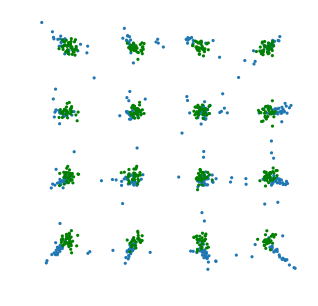

 40%|████      | 8014/20001 [05:53<08:48, 22.67it/s]

dist =  0.013131349058091353
kl =  1.3911164723012028


 41%|████      | 8211/20001 [06:01<08:39, 22.68it/s]

dist =  0.014758998490101172
kl =  1.2258803977453758


 42%|████▏     | 8411/20001 [06:10<08:30, 22.70it/s]

dist =  0.008828775123181441
kl =  0.4999018462966309


 43%|████▎     | 8610/20001 [06:19<08:21, 22.71it/s]

dist =  0.012767191419487784
kl =  0.9718568630299829


 44%|████▍     | 8808/20001 [06:27<08:12, 22.73it/s]

dist =  0.01120451882166876
kl =  0.6506379039428891


 45%|████▌     | 9008/20001 [06:36<08:03, 22.74it/s]

dist =  0.011161174938975199
kl =  0.6448578585896789


 46%|████▌     | 9210/20001 [06:44<07:54, 22.75it/s]

dist =  0.009870360577369891
kl =  0.5715315255516358


 47%|████▋     | 9407/20001 [06:53<07:45, 22.75it/s]

dist =  0.01445864810380308
kl =  0.9842771376500572


 48%|████▊     | 9612/20001 [07:02<07:36, 22.75it/s]

dist =  0.014800573649619904
kl =  0.81347668003861


 49%|████▉     | 9808/20001 [07:11<07:27, 22.75it/s]

dist =  0.010861611848172787
kl =  0.6554644040726862


 50%|████▉     | 9998/20001 [07:13<07:14, 23.04it/s]

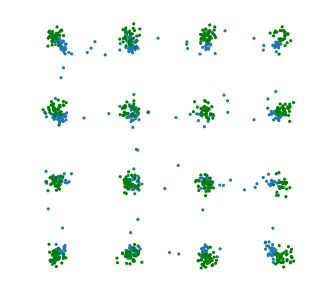

 50%|█████     | 10012/20001 [07:19<07:18, 22.78it/s]

dist =  0.014597437365836187
kl =  1.0417724583378645


 51%|█████     | 10211/20001 [07:28<07:09, 22.78it/s]

dist =  0.010745418455632101
kl =  0.9139593701703297


 52%|█████▏    | 10408/20001 [07:36<07:00, 22.79it/s]

dist =  0.015177583394080022
kl =  0.9545020317462218


 53%|█████▎    | 10609/20001 [07:45<06:52, 22.79it/s]

dist =  0.010082997848745135
kl =  0.4543652296934506


 54%|█████▍    | 10807/20001 [07:54<06:43, 22.80it/s]

dist =  0.007346892429644846
kl =  0.4320423752679594


 55%|█████▌    | 11007/20001 [08:02<06:34, 22.81it/s]

dist =  0.010794026693157967
kl =  0.4968301278716405


 56%|█████▌    | 11208/20001 [08:10<06:25, 22.83it/s]

dist =  0.009542874874054204
kl =  0.5732317704895928


 57%|█████▋    | 11414/20001 [08:19<06:15, 22.84it/s]

dist =  0.007369677560970141
kl =  0.6153454408301675


 58%|█████▊    | 11608/20001 [08:28<06:07, 22.82it/s]

dist =  0.010825983765280314
kl =  0.9216842308588689


 59%|█████▉    | 11810/20001 [08:37<05:58, 22.83it/s]

dist =  0.01295700578704074
kl =  0.8864859612798419


 60%|█████▉    | 11995/20001 [08:40<05:47, 23.06it/s]

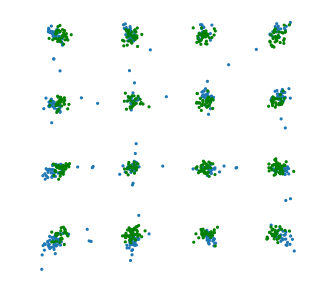

 60%|██████    | 12010/20001 [08:46<05:49, 22.83it/s]

dist =  0.012326625295748133
kl =  0.7123366090190246


 61%|██████    | 12210/20001 [08:55<05:41, 22.82it/s]

dist =  0.009497910446671901
kl =  0.5004578469144199


 62%|██████▏   | 12407/20001 [09:03<05:32, 22.83it/s]

dist =  0.011562371619027465
kl =  0.6922522671126887


 63%|██████▎   | 12608/20001 [09:11<05:23, 22.84it/s]

dist =  0.008715211949586769
kl =  0.48333209388450094


 64%|██████▍   | 12808/20001 [09:20<05:14, 22.86it/s]

dist =  0.008176996761270027
kl =  0.4624862229668625


 65%|██████▌   | 13009/20001 [09:28<05:05, 22.88it/s]

dist =  0.013312778217086645
kl =  0.6070267885131133


 66%|██████▌   | 13209/20001 [09:36<04:56, 22.89it/s]

dist =  0.014005534792514672
kl =  1.0482675318628112


 67%|██████▋   | 13412/20001 [09:45<04:47, 22.90it/s]

dist =  0.011507386098137127
kl =  0.4640643413273291


 68%|██████▊   | 13612/20001 [09:54<04:38, 22.91it/s]

dist =  0.010597434394734775
kl =  0.531758477567553


 69%|██████▉   | 13812/20001 [10:02<04:30, 22.92it/s]

dist =  0.02366766716505135
kl =  1.2044044211187597


 70%|██████▉   | 13999/20001 [10:05<04:19, 23.11it/s]

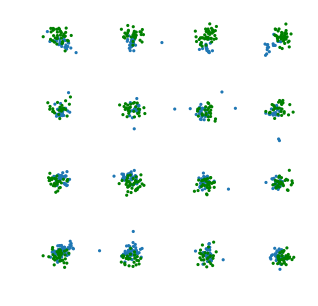

 70%|███████   | 14013/20001 [10:11<04:21, 22.92it/s]

dist =  0.014188618171822263
kl =  0.8628690680111579


 71%|███████   | 14206/20001 [10:19<04:12, 22.92it/s]

dist =  0.00833245557330682
kl =  0.3870608952846908


 72%|███████▏  | 14406/20001 [10:28<04:04, 22.92it/s]

dist =  0.00959812680326197
kl =  0.530639415438829


 73%|███████▎  | 14607/20001 [10:37<03:55, 22.92it/s]

dist =  0.008574278071910845
kl =  0.5626195274897845


 74%|███████▍  | 14808/20001 [10:45<03:46, 22.93it/s]

dist =  0.010594213890783718
kl =  0.5556048692763218


 75%|███████▌  | 15011/20001 [10:54<03:37, 22.93it/s]

dist =  0.010248151281368953
kl =  0.575781621914802


 76%|███████▌  | 15213/20001 [11:03<03:28, 22.94it/s]

dist =  0.010550844409840944
kl =  0.5799547348004999


 77%|███████▋  | 15414/20001 [11:11<03:19, 22.95it/s]

dist =  0.009877315300917738
kl =  0.5641887531212681


 78%|███████▊  | 15612/20001 [11:20<03:11, 22.96it/s]

dist =  0.009000047486989874
kl =  0.46376395990767527


 79%|███████▉  | 15810/20001 [11:28<03:02, 22.95it/s]

dist =  0.007556223148344733
kl =  0.3344828621495739


 80%|███████▉  | 15997/20001 [11:32<02:53, 23.11it/s]

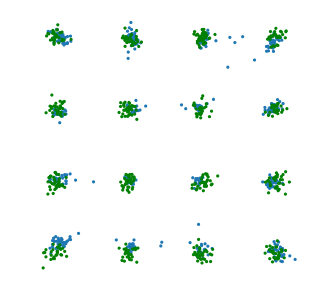

 80%|████████  | 16004/20001 [11:39<02:54, 22.88it/s]

dist =  0.01399247037822462
kl =  0.7789966325840889


 81%|████████  | 16205/20001 [11:55<02:47, 22.65it/s]

dist =  0.010722511208995223
kl =  0.7151038862653118


 82%|████████▏ | 16404/20001 [12:10<02:40, 22.46it/s]

dist =  0.010985538959928758
kl =  0.7678427807689006


 83%|████████▎ | 16605/20001 [12:27<02:32, 22.20it/s]

dist =  0.013033692421499299
kl =  0.6384719880272569


 84%|████████▍ | 16806/20001 [12:40<02:24, 22.10it/s]

dist =  0.01071638888696771
kl =  0.45520477797215486


 85%|████████▌ | 17009/20001 [12:49<02:15, 22.11it/s]

dist =  0.00887791974998813
kl =  0.3863519052594313


 86%|████████▌ | 17210/20001 [12:58<02:06, 22.12it/s]

dist =  0.009242922231421999
kl =  0.5157650270916303


 87%|████████▋ | 17411/20001 [13:07<01:57, 22.12it/s]

dist =  0.01599062224138496
kl =  0.7633268386595153


 88%|████████▊ | 17611/20001 [13:15<01:47, 22.14it/s]

dist =  0.014608257687586666
kl =  0.6266991635235737


 89%|████████▉ | 17808/20001 [13:23<01:38, 22.16it/s]

dist =  0.013211592754285321
kl =  0.7260152091600989


 90%|████████▉ | 18000/20001 [13:26<01:29, 22.32it/s]

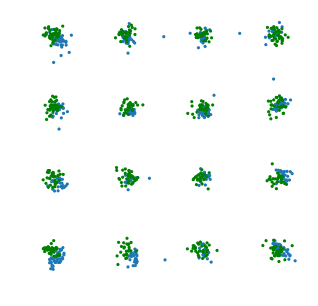

 90%|█████████ | 18009/20001 [13:32<01:29, 22.18it/s]

dist =  0.014192624947140178
kl =  0.6959024298988252


 91%|█████████ | 18208/20001 [13:39<01:20, 22.21it/s]

dist =  0.009251978441682017
kl =  0.5456244484194364


 92%|█████████▏| 18408/20001 [13:47<01:11, 22.24it/s]

dist =  0.014435311782165143
kl =  0.7655495560306718


 93%|█████████▎| 18613/20001 [13:55<01:02, 22.28it/s]

dist =  0.013684216802558746
kl =  0.859931293297223


 94%|█████████▍| 18810/20001 [14:03<00:53, 22.31it/s]

dist =  0.01079310651253955
kl =  0.5841995728771416


 95%|█████████▌| 19010/20001 [14:10<00:44, 22.35it/s]

dist =  0.017806822553206304
kl =  0.7785573513700199


 96%|█████████▌| 19211/20001 [14:18<00:35, 22.38it/s]

dist =  0.012005938586722777
kl =  0.48171246829322234


 97%|█████████▋| 19411/20001 [14:26<00:26, 22.41it/s]

dist =  0.01087485437596078
kl =  0.6964181952632971


 98%|█████████▊| 19607/20001 [14:33<00:17, 22.45it/s]

dist =  0.013630706598794983
kl =  0.8910561090286233


 99%|█████████▉| 19813/20001 [14:41<00:08, 22.47it/s]

dist =  0.014526648225647332
kl =  0.6977246615436976


100%|█████████▉| 19992/20001 [14:43<00:00, 22.62it/s]

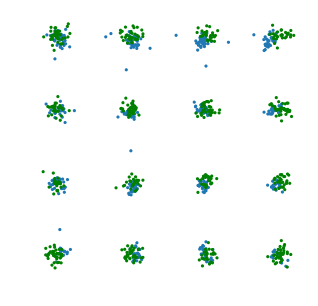

100%|██████████| 20001/20001 [14:49<00:00, 22.49it/s]

dist =  0.0156434481933207
kl =  0.6882247376269293


In [12]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
#     f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    f, _= sess.run([[loss], train_op])

    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         plt.xlim([-5.5, 5.5])
#         plt.ylim([-5.5, 5.5])
        axis('off')
        show()
        
    if (i) % nn_every == 0:
        x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
        l2nn = nn_l2_mean(x,y_ref)
        kl =estimate(x, y_ref,k=1)
        nn_dist.append(l2nn)
        nn_kl.append(kl)
        print('dist = ', l2nn)
        print('kl = ', kl)

    

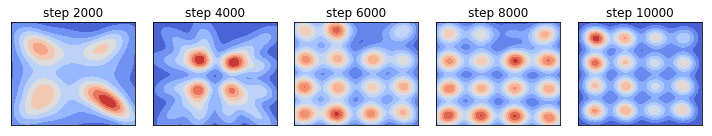

In [13]:
np_samples_ = np_samples[1:6]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=10, clip=[[-6,6]]*2)

#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%((i+1)*viz_every))
gcf().tight_layout()

In [ ]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [11]:
np.save('plot_con_kl',nn_kl)
np.save('plot_con_nn',nn_dist)